<a href="https://cognitiveclass.ai"><img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width = 400> </a>

<h1 align=center><font size = 5>Peer Review Final Assignment</font></h1>

## Introduction


In this lab, you will build an image classifier using the VGG16 pre-trained model, and you will evaluate it and compare its performance to the model we built in the last module using the ResNet50 pre-trained model. Good luck!

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>    

1. <a href="#item41">Download Data 
2. <a href="#item42">Part 1</a>
3. <a href="#item43">Part 2</a>  
4. <a href="#item44">Part 3</a>  

</font>
    
</div>

<a id="item41"></a>

## Download Data

Use the <code>wget</code> command to download the data for this assignment from here: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip

Use the following cells to download the data.

In [1]:
# CUDF - GPU Dataframe
# cudf is a GPU DataFrame library for loading, joining, aggregating, filtering, and otherwise manipulating tabular data using a DataFrame style API.    
%load_ext cudf.pandas

#=============================
# Autoreload for executing external Python code
%load_ext autoreload
%autoreload 2
#=============================
# Import propietary libraries

import sys


sys.path.append('/home/min0/development/AIFlow_Tools/')
# Function to download files from a given url and save them in a given path with a name 
# Usage: dl(path, 'NameFile.csv')
from AiFlow_Functions import dl_data as dl
# Function to Interprete the Jaccard Index 
# Example usage
# jaccard_value = 0.625
# print(interpret_jaccard(jaccard_value))
from AiFlow_Functions import interpret_jaccard as ij
# Function to interpret the confusion matrix
# Example usage
# cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
# print(explain_and_interpret_confusion_matrix(cnf_matrix))
from AiFlow_Functions import explain_and_interpret_confusion_matrix as explain_matrix
# Function to connect to any datasource and retrieve data and files 
# This function use now API, DL and Gdrive as data sources
# Example usage
# connector(url='http://example.com/data.csv', type='url', filename='downloaded_data.csv')
# connector(url='http://api.example.com/data', type='api', chunks=2)
# connector(type='google_drive', drive_file_id='drive_file_id_here', filename='drive_data.csv')
# google auth is in the same folder of the function set.
from AiFlow_Functions import connector as connector

# Function to load and predict with a given model and data it need the classes
# from AiFlow_Functions import load_and_p as AILoad_p
# from AiFlow_Functions import AIFlow_load_predict as AILoad_p
# Remove the warnings from the notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Importing libraries
#=============================
# import sweetviz in the notebook   
import io
import requests
# import sweetviz as sv
# import cudf
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# import folium
#=============================

In [2]:
url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip"

filename = "concrete_data_week4.zip"

dl(url, filename)

# Unzip the file
import zipfile
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('./')


In [4]:
os.listdir('./concrete_data_week4')
dataset_dir = './concrete_data_week4'

After you unzip the data, you fill find the data has already been divided into a train, validation, and test sets.

<a id="item42"></a>

## Part 1

In this part, you will design a classifier using the VGG16 pre-trained model. Just like the ResNet50 model, you can import the model <code>VGG16</code> from <code>keras.applications</code>.

You will essentially build your classifier as follows:
1. Import libraries, modules, and packages you will need. Make sure to import the *preprocess_input* function from <code>keras.applications.vgg16</code>.
2. Use a batch size of 100 images for both training and validation.
3. Construct an ImageDataGenerator for the training set and another one for the validation set. VGG16 was originally trained on 224 × 224 images, so make sure to address that when defining the ImageDataGenerator instances.
4. Create a sequential model using Keras. Add VGG16 model to it and dense layer.
5. Compile the mode using the adam optimizer and the categorical_crossentropy loss function.
6. Fit the model on the augmented data using the ImageDataGenerators.

Use the following cells to create your classifier.

## Import all dependency 

### Keras and Vgg16

In [34]:
import keras

from keras.applications import VGG16  # VGG16 is a pre-trained model
from keras.applications import ResNet50 # ResNet50 is a pre-trained model


from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

from keras.layers import Dropout
from keras.regularizers import l2



Define classes, batches and image resize.

In [35]:
num_classes = 2 # binary classification

image_resize = 224 # VGG16 takes 224 x 224 images as input  

batch_size_training = 100 # training data is in batches of 100 images

batch_size_validation = 100 # validation data is in batches of 100 images


In [ ]:
dataset_dir = './concrete_data_week4'
training_data = dataset_dir + '/train'
validation_data = dataset_dir + '/valid'

# Data augmentation for training data this way i have way more data to train

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Regular ImageDataGenerator for validation data
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# Train and Validation Generators
train_generator = train_datagen.flow_from_directory(
    training_data,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical'
)




Found 30001 images belonging to 2 classes.
Found 9501 images belonging to 2 classes.


## Build, compile the model - VGG16 - Adam - Softmax - Callback

#### To every model i add Callback to exit on 99.9% Accuracy 

In [92]:
# Building the VGG16 model

model_vgg = Sequential()

model_vgg.add(VGG16(include_top=False, pooling='avg', weights='imagenet'))

model_vgg.add(Dense(2048, activation='relu')) # adding a dense layer with 2048 neurons

model_vgg.add(Dense(2048, activation='relu')) # adding a dense layer with 2048 neurons

# model_vgg.add(Dropout(0.05)) # adding a dropout layer to avoid overfitting

model_vgg.add(Dense(num_classes, activation='softmax')) # adding a dense layer with softmax function as activation

model_vgg.layers[0].trainable = False # freezing the VGG16 model so that its weights will not be updated during training

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_75 (Dense)            (None, 2048)              1050624   
                                                                 
 dense_76 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_77 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 19965762 (76.16 MB)
Trainable params: 5251074 (20.03 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## Build, compile the model - ResNet50 - Adam - Softmax - Callback

#### To every model i add Callback to exit on 99.9% Accuracy 

In [93]:
# Building the ResNet50 model

model_resnet = Sequential()

model_resnet.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

model_resnet.add(Dense(2048, activation='relu')) # adding a dense layer with 2048 neurons

model_resnet.add(Dense(2048, activation='relu')) # adding a dense layer with 2048 neurons

model_resnet.add(Dense(num_classes, activation='softmax')) # adding a dense layer with softmax function as activation

model_resnet.layers[0].trainable = False

model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_resnet.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_78 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_79 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_80 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 31984514 (122.01 MB)
Trainable params: 8396802 (32.03 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


### Define training paramenters 

#### Since i play this on my GPU i will go for 100 epochs for both the models.

In [94]:
# Training Parameters

num_epochs = 100

steps_per_epoch_training = len(train_generator)

steps_per_epoch_validation = len(validation_generator)


### Define callback for early stopping 

In [95]:
# Define a Callback class that stops training once accuracy reaches 99%
from tensorflow.keras.callbacks import Callback

class myCallback(Callback):
  
  def on_epoch_end(self, epoch, logs={}):

    if(logs.get('accuracy')>0.997): # 99.7% accuracy reached to stop training - i added 0.7% to be sure that i will reach 99%
      
      print("\nReached 99.9% accuracy so cancelling training!")
      
      self.model.stop_training = True

### Control GPU for TF 

In [96]:
import tensorflow as tf

# List all physical devices available to TensorFlow
print("Available devices:", tf.config.list_physical_devices())


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Fit the VGG16 model

In [97]:
# calling my Callback class for early stopping

callbacks = myCallback()


# Training the VGG16 Model

fit_history_vgg = model_vgg.fit(

    train_generator,

    steps_per_epoch=steps_per_epoch_training,

    epochs=num_epochs,

    validation_data=validation_generator,

    validation_steps=steps_per_epoch_validation,
    
    callbacks=callbacks, # Early stopping 0n validation 
    
    verbose=1
)


Epoch 1/100
301/301 [==============================] - 114s 376ms/step - loss: 0.1174 - accuracy: 0.9824 - val_loss: 0.0079 - val_accuracy: 0.9971
Epoch 2/100
301/301 [==============================] - 115s 381ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.0074 - val_accuracy: 0.9973
Epoch 3/100
301/301 [==============================] - 114s 380ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.0092 - val_accuracy: 0.9971
Epoch 4/100
301/301 [==============================] - 114s 377ms/step - loss: 0.0132 - accuracy: 0.9963 - val_loss: 0.0076 - val_accuracy: 0.9974
Epoch 5/100
301/301 [==============================] - 115s 381ms/step - loss: 0.0124 - accuracy: 0.9969 - val_loss: 0.0068 - val_accuracy: 0.9975
Epoch 6/100
301/301 [==============================] - 115s 381ms/step - loss: 0.0120 - accuracy: 0.9966 - val_loss: 0.0054 - val_accuracy: 0.9979
Epoch 7/100
301/301 [==============================] - 113s 377ms/step - loss: 0.0125 - accuracy: 0.9962 - val_loss: 0

### Fit the ResNet50 Model

In [98]:
# calling my Callback class for early stopping

callbacks = myCallback()


# Training the ResNet50 Model

fit_history_resnet = model_resnet.fit(

    train_generator,

    steps_per_epoch=steps_per_epoch_training,

    epochs=num_epochs,

    validation_data=validation_generator,

    validation_steps=steps_per_epoch_validation,

    callbacks=callbacks, # Early stopping 0n validation 
    
    verbose=1

)

Epoch 1/100
301/301 [==============================] - 115s 374ms/step - loss: 0.0897 - accuracy: 0.9848 - val_loss: 0.0075 - val_accuracy: 0.9973
Epoch 2/100
301/301 [==============================] - 112s 372ms/step - loss: 0.0124 - accuracy: 0.9966 - val_loss: 0.0054 - val_accuracy: 0.9984
Epoch 3/100
301/301 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9977
Reached 99.9% accuracy so cancelling training!
301/301 [==============================] - 111s 369ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 0.0067 - val_accuracy: 0.9979


### Checking performances of the 2 models after Fit 

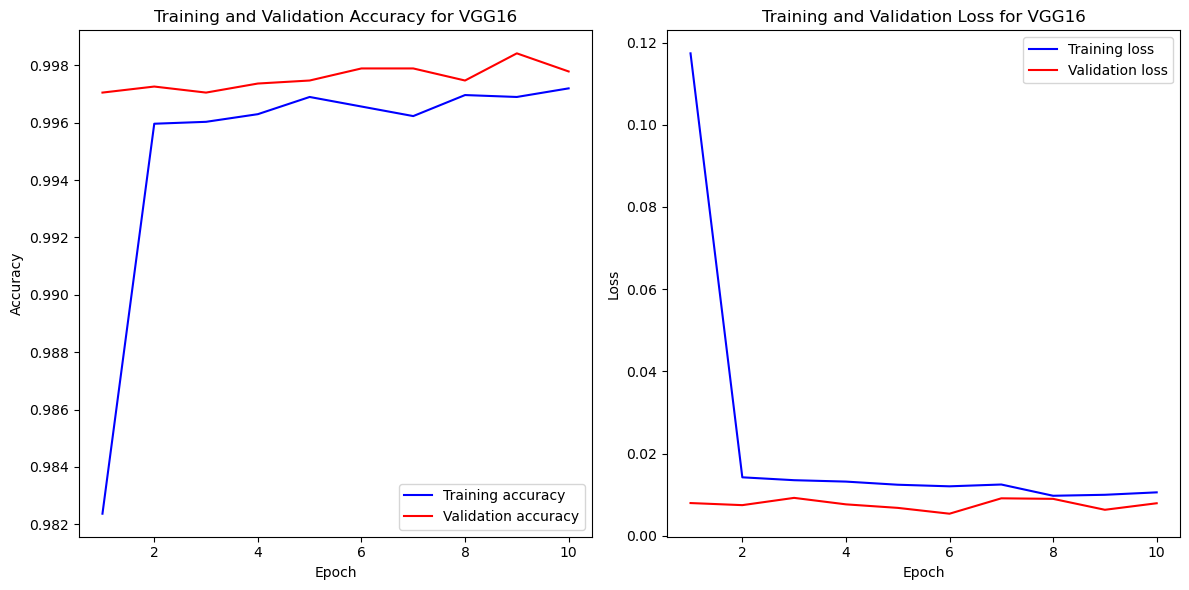

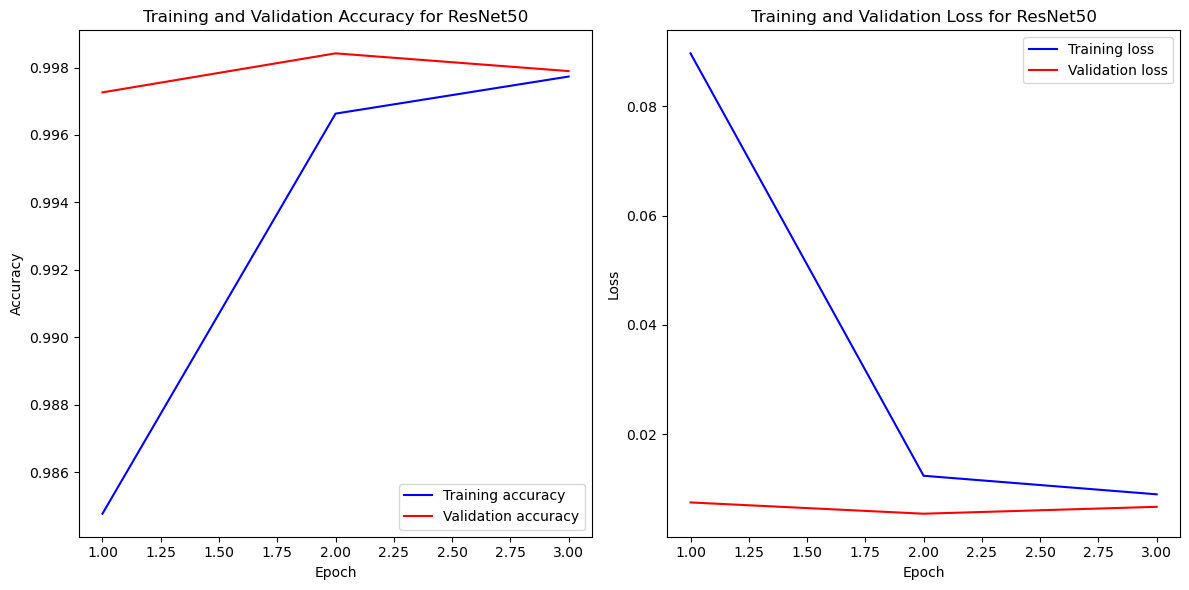

In [99]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy and loss
def plot_performance(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy for ' + model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss for ' + model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot performance for VGG16 model
plot_performance(fit_history_vgg, 'VGG16')

# Plot performance for ResNet50 model
plot_performance(fit_history_resnet, 'ResNet50')

### I Save both models for future use. After the 20 Epochs or Callback early stopping of training.

In [100]:
# Save the models
model_vgg.save('AIFlow_Pretrained_vgg16_model.h5')
model_resnet.save('AIFlow_Pretrained_resnet50_model.h5')

/home/min0/anaconda3/envs/AIFlow_Lab/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<a id="item43"></a>

## Part 2

In this part, you will evaluate your deep learning models on a test data. For this part, you will need to do the following:

1. Load your saved model that was built using the ResNet50 model. 
2. Construct an ImageDataGenerator for the test set. For this ImageDataGenerator instance, you only need to pass the directory of the test images, target size, and the **shuffle** parameter and set it to False.
3. Use the **evaluate_generator** method to evaluate your models on the test data, by passing the above ImageDataGenerator as an argument. You can learn more about **evaluate_generator** [here](https://keras.io/models/sequential/).
4. Print the performance of the classifier using the VGG16 pre-trained model.
5. Print the performance of the classifier using the ResNet pre-trained model.


Use the following cells to evaluate your models.

In [101]:
dataset_dir = './concrete_data_week4'
test_data = dataset_dir + '/test'

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Load the saved models from previous operation 

model_resnet = load_model('AIFlow_Pretrained_resnet50_model.h5')

model_vgg = load_model('AIFlow_Pretrained_vgg16_model.h5')

# ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Test Generator

test_generator = test_datagen.flow_from_directory(

    test_data, # using the validation data because the test data is not labeled 

    target_size=(image_resize, image_resize),

    batch_size=1,

    class_mode='categorical', 

    shuffle=False # shuffle=False to ensure that the predictions are in the same order as the IDs in the test_generator.filenames array
)

# Evaluate the ResNet model

resnet_evaluation = model_resnet.evaluate(test_generator)

print("ResNet Model - Loss: {:.4f}, Accuracy: {:.4f}".format(resnet_evaluation[0], resnet_evaluation[1]))

# Evaluate the VGG model

vgg_evaluation = model_vgg.evaluate(test_generator)

print("VGG Model - Loss: {:.4f}, Accuracy: {:.4f}".format(vgg_evaluation[0], vgg_evaluation[1]))


Found 500 images belonging to 2 classes.
500/500 [==============================] - 4s 7ms/step - loss: 0.0012 - accuracy: 1.0000
ResNet Model - Loss: 0.0012, Accuracy: 1.0000
500/500 [==============================] - 2s 3ms/step - loss: 0.0075 - accuracy: 0.9980
VGG Model - Loss: 0.0075, Accuracy: 0.9980


## Part 3

In this model, you will predict whether the images in the test data are images of cracked concrete or not. You will do the following:

1. Use the **predict_generator** method to predict the class of the images in the test data, by passing the test data ImageDataGenerator instance defined in the previous part as an argument. You can learn more about the **predict_generator** method [here](https://keras.io/models/sequential/).
2. Report the class predictions of the first five images in the test set. You should print something list this:

<center>
    <ul style="list-style-type:none">
        <li>Positive</li>  
        <li>Negative</li> 
        <li>Positive</li>
        <li>Positive</li>
        <li>Negative</li>
    </ul>
</center>

Use the following cells to make your predictions.

In [102]:
# Generate predictions for the test data
predictions_resnet = model_resnet.predict(test_generator, steps=len(test_generator))
predictions_vgg = model_vgg.predict(test_generator, steps=len(test_generator))

# Function to interpret the class predictions
def interpret_predictions(predictions):
    class_labels = ['Negative', 'Positive']  # 0: Negative, 1: Positive

    predicted_classes = [class_labels[np.argmax(pred)] for pred in predictions] # Get the predicted class label for each image

    return predicted_classes

# Interpret the first five predictions for each model 

first_five_predictions_resnet = interpret_predictions(predictions_resnet[:5])

first_five_predictions_vgg = interpret_predictions(predictions_vgg[:5])


# Print the class predictions of the first five images for each model

print("First Five Predictions with ResNet Model:")

for i, pred in enumerate(first_five_predictions_resnet):

    print(f"Image {i+1}: {pred}")

print("\nFirst Five Predictions with VGG Model:")

for i, pred in enumerate(first_five_predictions_vgg):
    
    print(f"Image {i+1}: {pred}")


500/500 [==============================] - 1s 2ms/step
First Five Predictions with ResNet Model:
Image 1: Negative
Image 2: Negative
Image 3: Negative
Image 4: Negative
Image 5: Negative

First Five Predictions with VGG Model:
Image 1: Negative
Image 2: Negative
Image 3: Negative
Image 4: Negative
Image 5: Negative


### Thank you for completing this lab!

This notebook was created by Alex Aklson.

This notebook is part of a course on **Coursera** called *AI Capstone Project with Deep Learning*. If you accessed this notebook outside the course, you can take this course online by clicking [here](https://cocl.us/DL0321EN_Coursera_Week4_LAB1).

<hr>

Copyright &copy; 2020 [IBM Developer Skills Network](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).